### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.10.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
------------------------------------------------------------------------------------------
[]
<function is_built_with_cuda at 0x0000014DDA8D8D30>

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# Chapter 5: Machine learning k-fold cross-validation

ASSUMPTION --> run for datasets ESC-10, BDLib2 and US8K:

* *01_Feature_extraction_exploration.ipynb*
* *02_PreProcessing_and_ML_modeling.ipynb* 

And run for the new dataset US8K_AV:
* *03_New_dataset_US8K_AV.ipynb*

After that, run for all datasets:
* *04_ML_modeling.ipynb*

***

## Importe modules

In [2]:
import librosa
import os
import glob
import warnings
import mimetypes
import itertools
import time
import sys

import pandas  as pd
import seaborn as sns
import numpy   as np
from IPython.display import display

from matplotlib  import pyplot as plt

from tqdm                      import tqdm

from sklearn                   import metrics
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn.decomposition     import PCA
from sklearn.metrics           import classification_report

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '05_Machine_learning_cross_validation_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

# Loading the dataset


In [4]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV



Select the dataset:  4


In [5]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [6]:
from MT_loadDataset import loadDataset

In [7]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4358
Total number of AUDIO files...........:  4358


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,...,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,...,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,...,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,...,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,...,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,...,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,...,1,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,...,1,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,...,1,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,...,1,99812,253.209850,255.741948,2


In [8]:
DB.dtypes

Fold                   int64
Folder_name           object
Class_OHEV            object
Class_categorical     object
File_name             object
Path                  object
classID                int64
fsID                   int64
start                float64
end                  float64
salience               int64
dtype: object

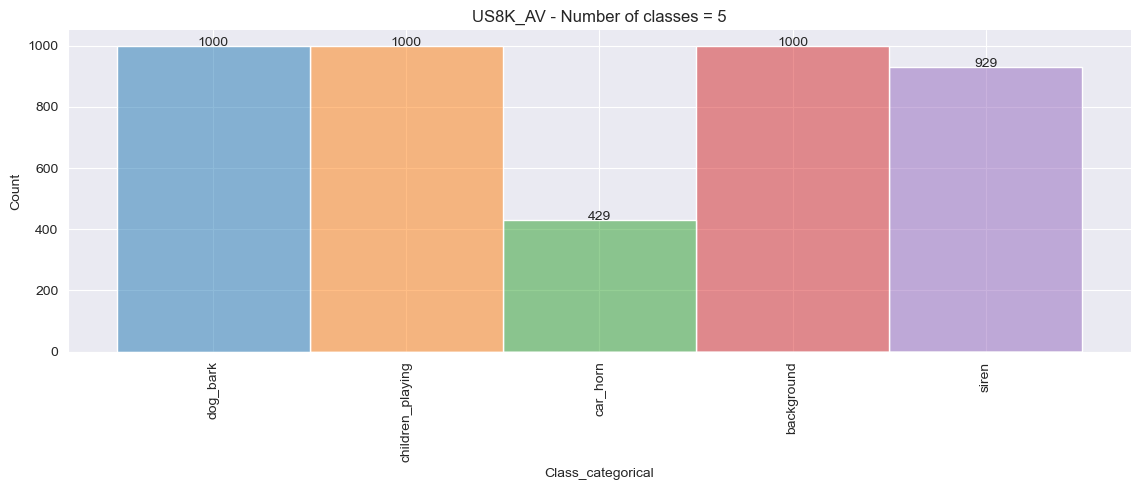

In [9]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [10]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K only windowed)



Select the dataset:  3


In [11]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

In [12]:
total_duration = 0
for audio in DB_from_pkl['Audio']:
    total_duration = total_duration + librosa.get_duration(y=audio)
print('Total duration of the dataset: ' , "{:0.4f} h".format(total_duration / 3600))

Total duration of the dataset:  8.4608 h


In [13]:
DB_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,...,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.117183,...,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.111724,...,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.124646,...,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.110741,...,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.125728,...,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...
30501,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.012771,...,-0.066230,0.033488,-0.069738,0.175013,-0.974133
30502,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007954,...,-0.022097,0.021007,-0.018432,-0.690702,-0.099409
30503,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008383,...,-0.013611,0.021124,-0.016391,-0.028383,-1.071243
30504,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.010459,...,-0.012274,0.027106,-0.017513,-0.121982,-0.606880


In [14]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         24449    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
car_horn           26255    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
children_playing   9776     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
dog_bark           17714    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
siren              18539    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Name: Class_OHEV, dtype: object


{'background': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'car_horn': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'children_playing': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'dog_bark': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'siren': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]}

In [15]:
nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

## ML Modeling

In [16]:
def get_mutual_info (X: list, X_val: list, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}\n')
    
    chi2_selector    = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    mutual_idx_train = chi2_selector.get_support(1)
    
    X_mutual     = X[X.columns[mutual_idx_train]] # final features
    X_val_mutual = X_val[X_val.columns[mutual_idx_train]] # final features

    print(f'X_train_mutual...: {X_mutual.shape}')
    print(f'X_val_mutual.....: {X_val_mutual.shape}\n')

    return X_mutual, X_val_mutual

In [17]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

In [18]:
# Pipeline to run the classifiers and their metrics using k-fold stratification according to the dataset specification

def model_classifiers(db: pd.DataFrame, 
                      scalerOpt: str, 
                      use_PCA = False,
                      use_mutual = False):
    
    if use_PCA:
        p = 2
    else:
        p = 1
    
    classifiers = ['Naïve Bayes', 'SVC', 'LogisticR', 'KNN', 'Forest', 'Voting']
    
    
    NB_c          = GaussianNB()
    SVC_c         = SVC(kernel = 'linear', C = 0.5, probability = True, random_state = SEED)
    LogisticR_c   = LogisticRegression(solver = 'saga', max_iter = 500, C = 0.5, n_jobs = -1)
    KNN_c         = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = p, leaf_size = 20, n_jobs = -1)
    forest_c      = RandomForestClassifier(n_estimators = 500, criterion = 'gini',bootstrap = True, n_jobs = -1)
    voting_c      = VotingClassifier(estimators = [(classifiers[0], NB_c),
                                                   (classifiers[1], SVC_c),
                                                   (classifiers[2], LogisticR_c),
                                                   (classifiers[3], KNN_c)],
                                     voting = 'soft')
    
    dic_classifiers = {'GaussianNB': NB_c, 
                       'SVC': SVC_c, 
                       'LogisticR' : LogisticR_c, 
                       'KNN': KNN_c, 
                       'Forest': forest_c, 
                       'Voting': voting_c}

    count       = 1
    ratio       = []
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Validation)',
                                                    'F1(Train)',
                                                    'F1(Validation)', 
                                                    'Precision(Train)',
                                                    'Precision(Validation)', 
                                                    'Recall(Train)',
                                                    'Recall(Validation)', 
                                                    'Conf_M',
                                                    'Process_time'])
    
    for fold in np.unique(db['Fold']):
        print(f"Validation fold: {fold}")
    
        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]
        
        X      = DB_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())

        X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

        X_mean   = X_statistics.values[:, 0]
        X_std    = X_statistics.values[:, 1]
        X_min    = X_statistics.values[:, 2]
        X_max    = X_statistics.values[:, 3]
        
        if scalerOpt == "normalization":
            X_train_norm = (X.values - X_min) / (X_max - X_min)
            X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
            batch_type    = '_norm'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        elif scalerOpt == "standardization":
            X_train_norm = (X.values - X_mean) / X_std
            X_val_norm   = (X_val.values - X_mean) / X_std
            batch_type    = '_std'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        else:
            sys.exit()
            
        if use_mutual:
            if scalerOpt == "standardization":
                print(f'Mutual information requires normalization!')
                sys.exit()
            else:
                X_train_norm, X_val_norm = get_mutual_info(X, X_val, X_train_norm, y)
                classifiers = ['Forest']
                dic_classifiers = {'Forest': forest_c}
                batch_type    = batch_type + '_mutual'
   
        if use_PCA:
            pcaT = PCA()
            pcaT.fit(X_train_norm)
            ratio = pcaT.explained_variance_ratio_
            
            batch_type = batch_type + '_PCA'
            
            T           = 0.98
            current_sum = 0
            countComp   = 0

            for element in ratio:
                current_sum += element
                countComp   += 1

                if current_sum >= T:
                    break

            # Print the result
            print(f'Sum of elements............: {current_sum}')
            print(f'Number of elements summed..: {countComp}\n')           
            
            pca          = PCA(n_components = countComp)
            X_train_norm = pca.fit_transform(X_train_norm)
            X_val_norm   = pca.transform(X_val_norm)
            
       
        for c in tqdm(dic_classifiers.items()):
            
            name         = c[0]
            model_name   = ('Model_' + c[0] + '_' + str(count))
            count        = count + 1
            model        = c[1]
            print(name)
            print(model)
            print(X_train_norm.shape)
            
            # Fitting the model to the classifier
            model.fit(X_train_norm, y)

            # Get the model predictions
            y_train_predicted = model.predict(X_train_norm)
            
            t_srt             = time.process_time_ns()
            y_val_predicited  = model.predict(X_val_norm)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)

            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val,  y_val_predicited)
            
            f1_Score_train = metrics.f1_score(y, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val,  y_val_predicited, average = 'weighted')

            precision_score_train = metrics.precision_score(y, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val,  y_val_predicited, average = 'weighted')

            recall_score_train = metrics.recall_score(y, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val,  y_val_predicited, average = 'weighted')

            class_report_val = classification_report(y_val, y_val_predicited)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val, y_val_predicited)

            # Store the name, validation accuracy results and model
            models.append((name, accuracy_val, model))
            
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Validation)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Validation)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Validation)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Validation)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time]})], ignore_index = True)
                   
    return acc_set, models, ratio, batch_type

In [19]:
# Option for scalerOpt is either "normalization" or "standardization"

# PCA with mutual is ilogical, results will be useless
# Mutual does not work with negative numbers, therefore "standardization" returns an error
# Mutual will trigger only Random Forest

metrics_set, models_set,  ratio, batch_name = model_classifiers(DB_from_pkl,
                                                                scalerOpt = 'standardization',
                                                                use_PCA = True,
                                                                use_mutual = False)

Validation fold: 1
X_train_norm shape...:(27496, 375)
X_val_norm shape.....:(3010, 375)

Sum of elements............: 0.9801846635764112
Number of elements summed..: 231



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27496, 231)


 17%|██████████████                                                                      | 1/6 [00:01<00:05,  1.06s/it]

                  precision    recall  f1-score   support

      background       0.81      0.28      0.42       756
        car_horn       0.21      0.48      0.29       252
children_playing       0.43      0.89      0.58       700
        dog_bark       0.75      0.40      0.52       700
           siren       0.46      0.27      0.34       602

        accuracy                           0.46      3010
       macro avg       0.53      0.46      0.43      3010
    weighted avg       0.59      0.46      0.45      3010

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27496, 231)


 33%|███████████████████████████▋                                                       | 2/6 [12:18<28:57, 434.32s/it]

                  precision    recall  f1-score   support

      background       0.82      0.77      0.79       756
        car_horn       0.76      0.90      0.83       252
children_playing       0.74      0.81      0.77       700
        dog_bark       0.81      0.79      0.80       700
           siren       0.82      0.75      0.79       602

        accuracy                           0.79      3010
       macro avg       0.79      0.80      0.80      3010
    weighted avg       0.79      0.79      0.79      3010

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27496, 231)


 50%|█████████████████████████████████████████▌                                         | 3/6 [14:12<14:24, 288.17s/it]

                  precision    recall  f1-score   support

      background       0.87      0.74      0.80       756
        car_horn       0.79      0.91      0.85       252
children_playing       0.75      0.81      0.78       700
        dog_bark       0.78      0.81      0.79       700
           siren       0.80      0.79      0.79       602

        accuracy                           0.80      3010
       macro avg       0.80      0.81      0.80      3010
    weighted avg       0.80      0.80      0.80      3010

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27496, 231)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [14:19<05:54, 177.17s/it]

                  precision    recall  f1-score   support

      background       0.83      0.67      0.74       756
        car_horn       0.76      0.84      0.80       252
children_playing       0.61      0.87      0.72       700
        dog_bark       0.78      0.67      0.72       700
           siren       0.84      0.74      0.79       602

        accuracy                           0.74      3010
       macro avg       0.77      0.76      0.75      3010
    weighted avg       0.76      0.74      0.74      3010

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27496, 231)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [16:48<02:47, 167.03s/it]

                  precision    recall  f1-score   support

      background       0.85      0.79      0.82       756
        car_horn       0.87      0.82      0.84       252
children_playing       0.75      0.79      0.77       700
        dog_bark       0.76      0.83      0.79       700
           siren       0.86      0.83      0.85       602

        accuracy                           0.81      3010
       macro avg       0.82      0.81      0.81      3010
    weighted avg       0.81      0.81      0.81      3010

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [35:06<00:00, 351.14s/it]

                  precision    recall  f1-score   support

      background       0.92      0.68      0.78       756
        car_horn       0.80      0.95      0.87       252
children_playing       0.64      0.92      0.75       700
        dog_bark       0.82      0.72      0.77       700
           siren       0.86      0.75      0.80       602

        accuracy                           0.78      3010
       macro avg       0.81      0.80      0.80      3010
    weighted avg       0.81      0.78      0.78      3010

Validation fold: 10


X_train_norm shape...:(27573, 375)
X_val_norm shape.....:(2933, 375)

Sum of elements............: 0.9800710149454922
Number of elements summed..: 234



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27573, 234)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.27s/it]

                  precision    recall  f1-score   support

      background       0.71      0.22      0.34       721
        car_horn       0.29      0.39      0.33       231
children_playing       0.35      0.91      0.51       700
        dog_bark       0.66      0.38      0.48       700
           siren       0.60      0.18      0.27       581

        accuracy                           0.43      2933
       macro avg       0.52      0.42      0.39      2933
    weighted avg       0.56      0.43      0.40      2933

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27573, 234)


 33%|███████████████████████████▋                                                       | 2/6 [14:57<35:10, 527.56s/it]

                  precision    recall  f1-score   support

      background       0.82      0.89      0.86       721
        car_horn       0.80      0.71      0.75       231
children_playing       0.66      0.84      0.74       700
        dog_bark       0.71      0.72      0.72       700
           siren       0.80      0.47      0.59       581

        accuracy                           0.74      2933
       macro avg       0.76      0.73      0.73      2933
    weighted avg       0.75      0.74      0.73      2933

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27573, 234)


 50%|█████████████████████████████████████████▌                                         | 3/6 [17:39<18:01, 360.65s/it]

                  precision    recall  f1-score   support

      background       0.88      0.87      0.87       721
        car_horn       0.83      0.73      0.78       231
children_playing       0.63      0.85      0.73       700
        dog_bark       0.74      0.72      0.73       700
           siren       0.79      0.54      0.64       581

        accuracy                           0.75      2933
       macro avg       0.77      0.74      0.75      2933
    weighted avg       0.77      0.75      0.75      2933

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27573, 234)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [17:46<07:22, 221.23s/it]

                  precision    recall  f1-score   support

      background       0.74      0.66      0.70       721
        car_horn       0.66      0.50      0.57       231
children_playing       0.47      0.85      0.61       700
        dog_bark       0.84      0.58      0.68       700
           siren       0.66      0.44      0.53       581

        accuracy                           0.63      2933
       macro avg       0.68      0.60      0.62      2933
    weighted avg       0.68      0.63      0.63      2933

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27573, 234)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [20:04<03:10, 190.99s/it]

                  precision    recall  f1-score   support

      background       0.81      0.83      0.82       721
        car_horn       0.90      0.58      0.71       231
children_playing       0.55      0.81      0.66       700
        dog_bark       0.80      0.71      0.75       700
           siren       0.72      0.48      0.58       581

        accuracy                           0.71      2933
       macro avg       0.76      0.68      0.70      2933
    weighted avg       0.74      0.71      0.71      2933

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [38:04<00:00, 380.73s/it]

                  precision    recall  f1-score   support

      background       0.89      0.74      0.81       721
        car_horn       0.81      0.67      0.73       231
children_playing       0.51      0.95      0.66       700
        dog_bark       0.89      0.67      0.76       700
           siren       0.85      0.45      0.59       581

        accuracy                           0.71      2933
       macro avg       0.79      0.70      0.71      2933
    weighted avg       0.78      0.71      0.71      2933

Validation fold: 2


X_train_norm shape...:(27503, 375)
X_val_norm shape.....:(3003, 375)

Sum of elements............: 0.9802557517920008
Number of elements summed..: 233



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27503, 233)


 17%|██████████████                                                                      | 1/6 [00:01<00:05,  1.16s/it]

                  precision    recall  f1-score   support

      background       0.62      0.13      0.22       672
        car_horn       0.30      0.32      0.31       294
children_playing       0.37      0.97      0.54       700
        dog_bark       0.69      0.39      0.50       700
           siren       0.57      0.29      0.38       637

        accuracy                           0.44      3003
       macro avg       0.51      0.42      0.39      3003
    weighted avg       0.54      0.44      0.40      3003

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27503, 233)


 33%|███████████████████████████▋                                                       | 2/6 [15:33<36:35, 548.88s/it]

                  precision    recall  f1-score   support

      background       0.69      0.72      0.71       672
        car_horn       0.74      0.63      0.68       294
children_playing       0.72      0.88      0.79       700
        dog_bark       0.85      0.78      0.82       700
           siren       0.89      0.77      0.82       637

        accuracy                           0.77      3003
       macro avg       0.78      0.76      0.76      3003
    weighted avg       0.78      0.77      0.78      3003

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27503, 233)


 50%|█████████████████████████████████████████▌                                         | 3/6 [18:01<18:17, 365.85s/it]

                  precision    recall  f1-score   support

      background       0.72      0.71      0.72       672
        car_horn       0.76      0.58      0.66       294
children_playing       0.68      0.88      0.77       700
        dog_bark       0.85      0.77      0.81       700
           siren       0.86      0.77      0.81       637

        accuracy                           0.77      3003
       macro avg       0.77      0.74      0.75      3003
    weighted avg       0.77      0.77      0.77      3003

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27503, 233)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [18:08<07:28, 224.37s/it]

                  precision    recall  f1-score   support

      background       0.54      0.51      0.52       672
        car_horn       0.57      0.39      0.46       294
children_playing       0.52      0.87      0.65       700
        dog_bark       0.85      0.63      0.72       700
           siren       0.72      0.55      0.62       637

        accuracy                           0.62      3003
       macro avg       0.64      0.59      0.60      3003
    weighted avg       0.65      0.62      0.62      3003

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27503, 233)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [20:15<03:09, 189.25s/it]

                  precision    recall  f1-score   support

      background       0.71      0.77      0.74       672
        car_horn       0.79      0.38      0.51       294
children_playing       0.62      0.92      0.74       700
        dog_bark       0.85      0.81      0.83       700
           siren       0.84      0.58      0.69       637

        accuracy                           0.73      3003
       macro avg       0.76      0.69      0.70      3003
    weighted avg       0.76      0.73      0.73      3003

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [37:06<00:00, 371.04s/it]

                  precision    recall  f1-score   support

      background       0.73      0.55      0.63       672
        car_horn       0.78      0.63      0.70       294
children_playing       0.53      0.96      0.68       700
        dog_bark       0.91      0.72      0.80       700
           siren       0.87      0.61      0.72       637

        accuracy                           0.70      3003
       macro avg       0.76      0.69      0.71      3003
    weighted avg       0.76      0.70      0.71      3003

Validation fold: 3


X_train_norm shape...:(27132, 375)
X_val_norm shape.....:(3374, 375)

Sum of elements............: 0.9802037458487682
Number of elements summed..: 233



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27132, 233)


 17%|██████████████                                                                      | 1/6 [00:01<00:05,  1.17s/it]

                  precision    recall  f1-score   support

      background       0.52      0.15      0.23       840
        car_horn       0.53      0.92      0.68       301
children_playing       0.32      0.88      0.47       700
        dog_bark       0.77      0.38      0.51       700
           siren       0.67      0.28      0.40       833

        accuracy                           0.45      3374
       macro avg       0.56      0.52      0.46      3374
    weighted avg       0.57      0.45      0.42      3374

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27132, 233)


 33%|███████████████████████████▋                                                       | 2/6 [13:27<31:39, 474.99s/it]

                  precision    recall  f1-score   support

      background       0.72      0.78      0.75       840
        car_horn       0.82      0.97      0.89       301
children_playing       0.73      0.76      0.74       700
        dog_bark       0.81      0.71      0.76       700
           siren       0.87      0.80      0.84       833

        accuracy                           0.78      3374
       macro avg       0.79      0.80      0.80      3374
    weighted avg       0.79      0.78      0.78      3374

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27132, 233)


 50%|█████████████████████████████████████████▌                                         | 3/6 [15:59<16:21, 327.15s/it]

                  precision    recall  f1-score   support

      background       0.73      0.74      0.73       840
        car_horn       0.86      0.98      0.91       301
children_playing       0.71      0.76      0.73       700
        dog_bark       0.78      0.72      0.75       700
           siren       0.85      0.80      0.82       833

        accuracy                           0.77      3374
       macro avg       0.78      0.80      0.79      3374
    weighted avg       0.78      0.77      0.77      3374

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27132, 233)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [16:06<06:41, 200.85s/it]

                  precision    recall  f1-score   support

      background       0.75      0.59      0.66       840
        car_horn       0.78      0.95      0.85       301
children_playing       0.55      0.88      0.68       700
        dog_bark       0.78      0.54      0.64       700
           siren       0.86      0.77      0.81       833

        accuracy                           0.72      3374
       macro avg       0.74      0.75      0.73      3374
    weighted avg       0.74      0.72      0.71      3374

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27132, 233)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [18:14<02:54, 174.50s/it]

                  precision    recall  f1-score   support

      background       0.82      0.85      0.83       840
        car_horn       0.90      0.94      0.92       301
children_playing       0.74      0.84      0.79       700
        dog_bark       0.87      0.74      0.80       700
           siren       0.86      0.82      0.84       833

        accuracy                           0.83      3374
       macro avg       0.84      0.84      0.84      3374
    weighted avg       0.83      0.83      0.83      3374

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [35:01<00:00, 350.21s/it]

                  precision    recall  f1-score   support

      background       0.86      0.70      0.77       840
        car_horn       0.84      0.99      0.91       301
children_playing       0.58      0.94      0.72       700
        dog_bark       0.91      0.62      0.74       700
           siren       0.91      0.79      0.85       833

        accuracy                           0.78      3374
       macro avg       0.82      0.81      0.80      3374
    weighted avg       0.82      0.78      0.78      3374

Validation fold: 4


X_train_norm shape...:(26733, 375)
X_val_norm shape.....:(3773, 375)

Sum of elements............: 0.9803348031146931
Number of elements summed..: 237



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(26733, 237)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.28s/it]

                  precision    recall  f1-score   support

      background       0.47      0.14      0.21       798
        car_horn       0.14      0.14      0.14       413
children_playing       0.23      0.76      0.36       700
        dog_bark       0.70      0.40      0.50       700
           siren       0.80      0.32      0.46      1162

        accuracy                           0.36      3773
       macro avg       0.47      0.35      0.33      3773
    weighted avg       0.53      0.36      0.36      3773

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(26733, 237)


 33%|███████████████████████████▋                                                       | 2/6 [13:18<31:17, 469.40s/it]

                  precision    recall  f1-score   support

      background       0.63      0.76      0.69       798
        car_horn       0.85      0.54      0.66       413
children_playing       0.69      0.62      0.65       700
        dog_bark       0.72      0.79      0.75       700
           siren       0.89      0.88      0.89      1162

        accuracy                           0.75      3773
       macro avg       0.76      0.72      0.73      3773
    weighted avg       0.76      0.75      0.75      3773

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(26733, 237)


 50%|█████████████████████████████████████████▌                                         | 3/6 [15:39<15:58, 319.43s/it]

                  precision    recall  f1-score   support

      background       0.64      0.81      0.72       798
        car_horn       0.85      0.50      0.63       413
children_playing       0.75      0.64      0.69       700
        dog_bark       0.73      0.80      0.76       700
           siren       0.89      0.89      0.89      1162

        accuracy                           0.77      3773
       macro avg       0.77      0.73      0.74      3773
    weighted avg       0.78      0.77      0.76      3773

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(26733, 237)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [15:46<06:32, 196.19s/it]

                  precision    recall  f1-score   support

      background       0.68      0.59      0.63       798
        car_horn       0.87      0.46      0.60       413
children_playing       0.37      0.77      0.50       700
        dog_bark       0.69      0.64      0.66       700
           siren       0.84      0.55      0.67      1162

        accuracy                           0.61      3773
       macro avg       0.69      0.60      0.61      3773
    weighted avg       0.70      0.61      0.62      3773

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(26733, 237)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [17:50<02:50, 170.16s/it]

                  precision    recall  f1-score   support

      background       0.68      0.76      0.72       798
        car_horn       0.95      0.38      0.54       413
children_playing       0.56      0.64      0.60       700
        dog_bark       0.70      0.80      0.74       700
           siren       0.90      0.85      0.87      1162

        accuracy                           0.73      3773
       macro avg       0.75      0.69      0.69      3773
    weighted avg       0.76      0.73      0.73      3773

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [33:08<00:00, 331.43s/it]

                  precision    recall  f1-score   support

      background       0.70      0.62      0.66       798
        car_horn       0.91      0.49      0.63       413
children_playing       0.43      0.79      0.56       700
        dog_bark       0.78      0.72      0.75       700
           siren       0.91      0.73      0.81      1162

        accuracy                           0.69      3773
       macro avg       0.75      0.67      0.68      3773
    weighted avg       0.75      0.69      0.70      3773

Validation fold: 5


X_train_norm shape...:(27230, 375)
X_val_norm shape.....:(3276, 375)

Sum of elements............: 0.9802872505448041
Number of elements summed..: 239



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27230, 239)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.23s/it]

                  precision    recall  f1-score   support

      background       0.58      0.26      0.35       693
        car_horn       0.20      0.15      0.17       686
children_playing       0.34      0.86      0.49       700
        dog_bark       0.57      0.32      0.41       700
           siren       0.41      0.25      0.31       497

        accuracy                           0.38      3276
       macro avg       0.42      0.37      0.35      3276
    weighted avg       0.42      0.38      0.35      3276

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27230, 239)


 33%|███████████████████████████▋                                                       | 2/6 [13:47<32:25, 486.44s/it]

                  precision    recall  f1-score   support

      background       0.63      0.81      0.71       693
        car_horn       0.89      0.66      0.76       686
children_playing       0.75      0.73      0.74       700
        dog_bark       0.76      0.75      0.75       700
           siren       0.81      0.84      0.83       497

        accuracy                           0.75      3276
       macro avg       0.77      0.76      0.76      3276
    weighted avg       0.77      0.75      0.75      3276

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27230, 239)


 50%|█████████████████████████████████████████▌                                         | 3/6 [15:50<16:01, 320.53s/it]

                  precision    recall  f1-score   support

      background       0.61      0.81      0.70       693
        car_horn       0.90      0.58      0.71       686
children_playing       0.75      0.73      0.74       700
        dog_bark       0.74      0.73      0.73       700
           siren       0.78      0.88      0.83       497

        accuracy                           0.74      3276
       macro avg       0.76      0.74      0.74      3276
    weighted avg       0.76      0.74      0.74      3276

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27230, 239)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [15:57<06:33, 196.64s/it]

                  precision    recall  f1-score   support

      background       0.64      0.72      0.68       693
        car_horn       0.91      0.62      0.74       686
children_playing       0.52      0.80      0.63       700
        dog_bark       0.79      0.54      0.64       700
           siren       0.82      0.81      0.81       497

        accuracy                           0.69      3276
       macro avg       0.74      0.70      0.70      3276
    weighted avg       0.73      0.69      0.69      3276

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27230, 239)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [18:04<02:51, 171.72s/it]

                  precision    recall  f1-score   support

      background       0.57      0.84      0.68       693
        car_horn       0.96      0.49      0.65       686
children_playing       0.66      0.70      0.68       700
        dog_bark       0.77      0.68      0.72       700
           siren       0.80      0.89      0.84       497

        accuracy                           0.71      3276
       macro avg       0.75      0.72      0.71      3276
    weighted avg       0.75      0.71      0.70      3276

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [32:23<00:00, 323.85s/it]

                  precision    recall  f1-score   support

      background       0.69      0.72      0.71       693
        car_horn       0.91      0.63      0.75       686
children_playing       0.56      0.85      0.68       700
        dog_bark       0.81      0.58      0.68       700
           siren       0.86      0.87      0.86       497

        accuracy                           0.72      3276
       macro avg       0.76      0.73      0.73      3276
    weighted avg       0.76      0.72      0.73      3276

Validation fold: 6


X_train_norm shape...:(27706, 375)
X_val_norm shape.....:(2800, 375)

Sum of elements............: 0.9803388072660862
Number of elements summed..: 233



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27706, 233)


 17%|██████████████                                                                      | 1/6 [00:01<00:05,  1.08s/it]

                  precision    recall  f1-score   support

      background       0.59      0.20      0.30       686
        car_horn       0.26      0.46      0.33       196
children_playing       0.37      0.85      0.52       700
        dog_bark       0.70      0.28      0.40       700
           siren       0.70      0.43      0.54       518

        accuracy                           0.45      2800
       macro avg       0.52      0.45      0.42      2800
    weighted avg       0.56      0.45      0.43      2800

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27706, 233)


 33%|███████████████████████████▋                                                       | 2/6 [13:50<32:33, 488.37s/it]

                  precision    recall  f1-score   support

      background       0.67      0.79      0.72       686
        car_horn       0.72      0.85      0.78       196
children_playing       0.76      0.86      0.81       700
        dog_bark       0.85      0.69      0.76       700
           siren       0.85      0.67      0.75       518

        accuracy                           0.76      2800
       macro avg       0.77      0.77      0.76      2800
    weighted avg       0.77      0.76      0.76      2800

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27706, 233)


 50%|█████████████████████████████████████████▌                                         | 3/6 [15:47<15:56, 318.95s/it]

                  precision    recall  f1-score   support

      background       0.72      0.79      0.75       686
        car_horn       0.77      0.91      0.83       196
children_playing       0.77      0.86      0.82       700
        dog_bark       0.85      0.72      0.78       700
           siren       0.81      0.68      0.74       518

        accuracy                           0.78      2800
       macro avg       0.78      0.79      0.78      2800
    weighted avg       0.78      0.78      0.78      2800

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27706, 233)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [15:54<06:31, 195.67s/it]

                  precision    recall  f1-score   support

      background       0.57      0.50      0.53       686
        car_horn       0.71      0.72      0.72       196
children_playing       0.54      0.87      0.66       700
        dog_bark       0.83      0.48      0.61       700
           siren       0.67      0.60      0.63       518

        accuracy                           0.62      2800
       macro avg       0.66      0.63      0.63      2800
    weighted avg       0.66      0.62      0.62      2800

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27706, 233)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [18:05<02:52, 172.30s/it]

                  precision    recall  f1-score   support

      background       0.63      0.78      0.70       686
        car_horn       0.87      0.66      0.75       196
children_playing       0.71      0.78      0.74       700
        dog_bark       0.81      0.68      0.74       700
           siren       0.85      0.73      0.79       518

        accuracy                           0.74      2800
       macro avg       0.77      0.73      0.74      2800
    weighted avg       0.75      0.74      0.74      2800

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [33:56<00:00, 339.40s/it]

                  precision    recall  f1-score   support

      background       0.76      0.63      0.69       686
        car_horn       0.80      0.87      0.83       196
children_playing       0.57      0.94      0.71       700
        dog_bark       0.91      0.60      0.72       700
           siren       0.86      0.67      0.75       518

        accuracy                           0.72      2800
       macro avg       0.78      0.74      0.74      2800
    weighted avg       0.77      0.72      0.72      2800

Validation fold: 7


X_train_norm shape...:(27671, 375)
X_val_norm shape.....:(2835, 375)

Sum of elements............: 0.9802503685859969
Number of elements summed..: 234



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27671, 234)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.22s/it]

                  precision    recall  f1-score   support

      background       0.52      0.19      0.28       700
        car_horn       0.18      0.24      0.21       196
children_playing       0.35      0.81      0.49       700
        dog_bark       0.77      0.43      0.55       700
           siren       0.30      0.17      0.22       539

        accuracy                           0.40      2835
       macro avg       0.42      0.37      0.35      2835
    weighted avg       0.47      0.40      0.38      2835

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27671, 234)


 33%|███████████████████████████▋                                                       | 2/6 [14:38<34:25, 516.28s/it]

                  precision    recall  f1-score   support

      background       0.68      0.74      0.71       700
        car_horn       0.82      0.65      0.73       196
children_playing       0.73      0.80      0.76       700
        dog_bark       0.84      0.86      0.85       700
           siren       0.74      0.59      0.66       539

        accuracy                           0.75      2835
       macro avg       0.76      0.73      0.74      2835
    weighted avg       0.75      0.75      0.75      2835

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27671, 234)


 50%|█████████████████████████████████████████▌                                         | 3/6 [17:05<17:24, 348.03s/it]

                  precision    recall  f1-score   support

      background       0.72      0.69      0.70       700
        car_horn       0.96      0.69      0.81       196
children_playing       0.72      0.79      0.75       700
        dog_bark       0.80      0.86      0.83       700
           siren       0.75      0.70      0.73       539

        accuracy                           0.76      2835
       macro avg       0.79      0.75      0.76      2835
    weighted avg       0.76      0.76      0.76      2835

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27671, 234)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [17:13<07:07, 213.51s/it]

                  precision    recall  f1-score   support

      background       0.57      0.54      0.55       700
        car_horn       0.63      0.45      0.53       196
children_playing       0.48      0.68      0.56       700
        dog_bark       0.78      0.64      0.70       700
           siren       0.54      0.46      0.50       539

        accuracy                           0.58      2835
       macro avg       0.60      0.55      0.57      2835
    weighted avg       0.60      0.58      0.58      2835

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27671, 234)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [19:23<03:03, 183.53s/it]

                  precision    recall  f1-score   support

      background       0.63      0.67      0.65       700
        car_horn       0.89      0.47      0.62       196
children_playing       0.64      0.70      0.67       700
        dog_bark       0.73      0.82      0.78       700
           siren       0.73      0.60      0.66       539

        accuracy                           0.69      2835
       macro avg       0.72      0.65      0.67      2835
    weighted avg       0.70      0.69      0.68      2835

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [36:39<00:00, 366.53s/it]

                  precision    recall  f1-score   support

      background       0.79      0.62      0.69       700
        car_horn       0.95      0.54      0.69       196
children_playing       0.56      0.91      0.69       700
        dog_bark       0.89      0.77      0.82       700
           siren       0.75      0.59      0.66       539

        accuracy                           0.72      2835
       macro avg       0.79      0.69      0.71      2835
    weighted avg       0.76      0.72      0.72      2835

Validation fold: 8


X_train_norm shape...:(27776, 375)
X_val_norm shape.....:(2730, 375)

Sum of elements............: 0.9800451063769955
Number of elements summed..: 234



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27776, 234)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.24s/it]

                  precision    recall  f1-score   support

      background       0.58      0.28      0.38       560
        car_horn       0.33      0.49      0.39       210
children_playing       0.39      0.80      0.53       700
        dog_bark       0.55      0.30      0.39       700
           siren       0.49      0.30      0.37       560

        accuracy                           0.44      2730
       macro avg       0.47      0.43      0.41      2730
    weighted avg       0.49      0.44      0.42      2730

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27776, 234)


 33%|███████████████████████████▋                                                       | 2/6 [14:50<34:53, 523.37s/it]

                  precision    recall  f1-score   support

      background       0.63      0.79      0.70       560
        car_horn       0.60      0.77      0.67       210
children_playing       0.79      0.68      0.73       700
        dog_bark       0.85      0.74      0.79       700
           siren       0.82      0.82      0.82       560

        accuracy                           0.75      2730
       macro avg       0.74      0.76      0.74      2730
    weighted avg       0.77      0.75      0.75      2730

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27776, 234)


 50%|█████████████████████████████████████████▌                                         | 3/6 [17:22<17:41, 353.96s/it]

                  precision    recall  f1-score   support

      background       0.64      0.83      0.72       560
        car_horn       0.70      0.84      0.77       210
children_playing       0.82      0.67      0.74       700
        dog_bark       0.86      0.75      0.80       700
           siren       0.80      0.83      0.82       560

        accuracy                           0.77      2730
       macro avg       0.77      0.78      0.77      2730
    weighted avg       0.78      0.77      0.77      2730

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27776, 234)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [17:29<07:14, 217.17s/it]

                  precision    recall  f1-score   support

      background       0.53      0.61      0.57       560
        car_horn       0.78      0.87      0.82       210
children_playing       0.55      0.72      0.62       700
        dog_bark       0.82      0.54      0.65       700
           siren       0.61      0.52      0.56       560

        accuracy                           0.62      2730
       macro avg       0.66      0.65      0.65      2730
    weighted avg       0.65      0.62      0.62      2730

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27776, 234)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [19:42<03:06, 186.78s/it]

                  precision    recall  f1-score   support

      background       0.54      0.75      0.63       560
        car_horn       0.97      0.92      0.94       210
children_playing       0.74      0.67      0.70       700
        dog_bark       0.84      0.73      0.78       700
           siren       0.71      0.64      0.67       560

        accuracy                           0.72      2730
       macro avg       0.76      0.74      0.75      2730
    weighted avg       0.73      0.72      0.72      2730

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [37:44<00:00, 377.44s/it]

                  precision    recall  f1-score   support

      background       0.70      0.67      0.68       560
        car_horn       0.71      0.87      0.78       210
children_playing       0.60      0.78      0.68       700
        dog_bark       0.95      0.61      0.74       700
           siren       0.80      0.82      0.81       560

        accuracy                           0.73      2730
       macro avg       0.75      0.75      0.74      2730
    weighted avg       0.76      0.73      0.73      2730

Validation fold: 9


X_train_norm shape...:(27734, 375)
X_val_norm shape.....:(2772, 375)

Sum of elements............: 0.980110730570213
Number of elements summed..: 235



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(27734, 235)


 17%|██████████████                                                                      | 1/6 [00:01<00:06,  1.28s/it]

                  precision    recall  f1-score   support

      background       0.72      0.36      0.48       574
        car_horn       0.36      0.51      0.42       224
children_playing       0.41      0.84      0.55       700
        dog_bark       0.66      0.32      0.43       700
           siren       0.70      0.50      0.58       574

        accuracy                           0.51      2772
       macro avg       0.57      0.50      0.49      2772
    weighted avg       0.59      0.51      0.50      2772

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(27734, 235)


 33%|███████████████████████████▋                                                       | 2/6 [15:48<37:11, 557.86s/it]

                  precision    recall  f1-score   support

      background       0.67      0.75      0.71       574
        car_horn       0.84      0.78      0.81       224
children_playing       0.76      0.76      0.76       700
        dog_bark       0.75      0.61      0.68       700
           siren       0.81      0.93      0.87       574

        accuracy                           0.76      2772
       macro avg       0.77      0.77      0.76      2772
    weighted avg       0.76      0.76      0.75      2772

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(27734, 235)


 50%|█████████████████████████████████████████▌                                         | 3/6 [18:27<18:47, 375.68s/it]

                  precision    recall  f1-score   support

      background       0.75      0.74      0.75       574
        car_horn       0.87      0.95      0.91       224
children_playing       0.75      0.77      0.76       700
        dog_bark       0.76      0.63      0.69       700
           siren       0.80      0.92      0.85       574

        accuracy                           0.77      2772
       macro avg       0.78      0.80      0.79      2772
    weighted avg       0.77      0.77      0.77      2772

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(27734, 235)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [18:35<07:40, 230.35s/it]

                  precision    recall  f1-score   support

      background       0.75      0.71      0.73       574
        car_horn       0.80      0.76      0.78       224
children_playing       0.61      0.84      0.71       700
        dog_bark       0.87      0.52      0.65       700
           siren       0.81      0.91      0.86       574

        accuracy                           0.74      2772
       macro avg       0.77      0.75      0.74      2772
    weighted avg       0.76      0.74      0.73      2772

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(27734, 235)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [20:51<03:16, 196.52s/it]

                  precision    recall  f1-score   support

      background       0.79      0.79      0.79       574
        car_horn       0.97      0.84      0.90       224
children_playing       0.71      0.81      0.76       700
        dog_bark       0.77      0.63      0.69       700
           siren       0.80      0.90      0.85       574

        accuracy                           0.78      2772
       macro avg       0.81      0.79      0.80      2772
    weighted avg       0.78      0.78      0.78      2772

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='saga')),
                             ('KNN',
             

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [39:02<00:00, 390.43s/it]

                  precision    recall  f1-score   support

      background       0.84      0.75      0.79       574
        car_horn       0.92      0.90      0.91       224
children_playing       0.64      0.91      0.75       700
        dog_bark       0.84      0.53      0.65       700
           siren       0.85      0.91      0.88       574

        accuracy                           0.78      2772
       macro avg       0.82      0.80      0.80      2772
    weighted avg       0.80      0.78      0.77      2772



In [20]:
batch_name

'_std_PCA'

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [21]:
metrics_set

,Model,Fold,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Conf_M,Process_time
0,GaussianNB,1,0.449993,0.463787,0.436752,...,0.586188,0.449993,0.463787,"[[214, 118, 330, 31, 63], [21, 121, 38, 7, 65], [13, 7, 620, 41, 19], [10, 68, 299, 280, 43], [7, 264, 155, 15, 161]]",46.875
1,SVC,1,0.883256,0.791030,0.883499,...,0.793812,0.883256,0.791030,"[[579, 35, 46, 51, 45], [14, 228, 0, 3, 7], [40, 1, 569, 67, 23], [15, 30, 80, 554, 21], [60, 6, 74, 11, 451]]",4328.125
2,LogisticR,1,0.850924,0.796013,0.851168,...,0.799550,0.850924,0.796013,"[[559, 26, 49, 60, 62], [6, 230, 0, 1, 15], [34, 1, 569, 71, 25], [11, 30, 77, 564, 18], [36, 3, 62, 27, 474]]",0.000
3,KNN,1,0.984871,0.743522,0.984881,...,0.764383,0.984871,0.743522,"[[507, 23, 104, 75, 47], [27, 211, 3, 3, 8], [25, 2, 609, 47, 17], [28, 36, 160, 466, 10], [23, 5, 121, 8, 445]]",4968.750
4,Forest,1,1.000000,0.808306,1.000000,...,0.811045,1.000000,0.808306,"[[595, 0, 45, 67, 49], [43, 206, 2, 0, 1], [37, 3, 552, 89, 19], [12, 28, 69, 578, 13], [13, 1, 64, 22, 502]]",1046.875
5,Voting,1,0.916715,0.782392,0.917781,...,0.809073,0.916715,0.782392,"[[516, 22, 115, 61, 42], [7, 239, 3, 0, 3], [10, 0, 642, 35, 13], [6, 29, 145, 505, 15], [24, 7, 106, 12, 453]]",10750.000
6,GaussianNB,10,0.454031,0.428912,0.440571,...,0.555750,0.454031,0.428912,"[[161, 91, 424, 23, 22], [25, 91, 90, 8, 17], [5, 2, 636, 41, 16], [22, 88, 308, 268, 14], [14, 45, 352, 68, 102]]",46.875
7,SVC,10,0.887499,0.740880,0.887777,...,0.750089,0.887499,0.740880,"[[645, 7, 35, 12, 22], [50, 164, 7, 8, 2], [18, 1, 588, 78, 15], [58, 16, 94, 502, 30], [15, 16, 172, 104, 274]]",5046.875
8,LogisticR,10,0.854931,0.751790,0.855215,...,0.765185,0.854931,0.751790,"[[624, 11, 39, 15, 32], [33, 168, 14, 16, 0], [12, 2, 594, 73, 19], [38, 14, 112, 506, 30], [6, 7, 179, 76, 313]]",0.000
9,KNN,10,0.985167,0.627344,0.985172,...,0.680044,0.985167,0.627344,"[[475, 37, 157, 17, 35], [29, 115, 75, 6, 6], [32, 2, 594, 26, 46], [52, 12, 192, 403, 41], [50, 7, 244, 27, 253]]",4203.125


In [22]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Validation)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Fold,Accuracy(Train),Accuracy(Validation),...,Precision(Validation),Recall(Train),Recall(Validation),Conf_M,Process_time
0,46,Forest,7,1.000000,0.686772,...,0.695093,1.000000,0.686772,"[[468, 2, 119, 77, 34], [45, 93, 39, 8, 11], [75, 10, 487, 84, 44], [35, 0, 59, 576, 30], [119, 0, 57, 40, 323]]",921.875
1,34,Forest,5,1.000000,0.707265,...,0.746875,1.000000,0.707265,"[[581, 0, 50, 43, 19], [280, 335, 34, 9, 28], [82, 5, 488, 79, 46], [54, 0, 155, 473, 18], [20, 10, 13, 14, 440]]",1031.250
2,10,Forest,10,1.000000,0.709853,...,0.735773,1.000000,0.709853,"[[601, 12, 53, 24, 31], [38, 134, 50, 3, 6], [16, 1, 570, 66, 47], [42, 2, 134, 499, 23], [42, 0, 228, 33, 278]]",796.875
3,52,Forest,8,1.000000,0.715751,...,0.734292,1.000000,0.715751,"[[418, 1, 38, 54, 49], [9, 194, 5, 0, 2], [149, 0, 469, 35, 47], [32, 2, 102, 514, 50], [164, 4, 22, 11, 359]]",859.375
4,28,Forest,4,1.000000,0.731513,...,0.755864,1.000000,0.731513,"[[608, 6, 116, 32, 36], [181, 156, 19, 23, 34], [88, 0, 449, 141, 22], [17, 1, 102, 561, 19], [3, 2, 121, 50, 986]]",1078.125
5,16,Forest,2,1.000000,0.734932,...,0.758739,1.000000,0.734932,"[[515, 6, 102, 35, 14], [96, 111, 52, 26, 9], [14, 0, 642, 23, 21], [24, 3, 79, 569, 25], [79, 21, 154, 13, 370]]",1015.625
6,40,Forest,6,1.000000,0.737857,...,0.752232,1.000000,0.737857,"[[533, 13, 81, 38, 21], [41, 130, 14, 10, 1], [64, 6, 549, 54, 27], [84, 1, 122, 476, 17], [119, 0, 9, 12, 378]]",906.250
7,58,Forest,9,1.000000,0.779942,...,0.783257,1.000000,0.779942,"[[455, 4, 40, 28, 47], [24, 188, 2, 2, 8], [17, 0, 564, 84, 35], [75, 1, 145, 439, 40], [3, 0, 38, 17, 516]]",937.500
8,4,Forest,1,1.000000,0.808306,...,0.811045,1.000000,0.808306,"[[595, 0, 45, 67, 49], [43, 206, 2, 0, 1], [37, 3, 552, 89, 19], [12, 28, 69, 578, 13], [13, 1, 64, 22, 502]]",1046.875
9,22,Forest,3,1.000000,0.827801,...,0.831616,1.000000,0.827801,"[[712, 26, 68, 11, 23], [0, 284, 0, 17, 0], [26, 3, 591, 45, 35], [25, 4, 102, 519, 50], [107, 0, 34, 5, 687]]",921.875


In [23]:
metrics_set[['Model', 'Accuracy(Validation)']].style.background_gradient(cmap = cmap_cm)

,Model,Accuracy(Validation)
0,Forest,0.686772
1,Forest,0.707265
2,Forest,0.709853
3,Forest,0.715751
4,Forest,0.731513
5,Forest,0.734932
6,Forest,0.737857
7,Forest,0.779942
8,Forest,0.808306
9,Forest,0.827801


In [24]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Validation)'].max()
highest_accuracy

Model
Forest        0.827801
GaussianNB    0.510823
KNN           0.743522
LogisticR     0.796013
SVC           0.791030
Voting        0.782392
Name: Accuracy(Validation), dtype: float64

In [25]:
list_classifiers = metrics_set['Model'].unique().tolist()
list_classifiers

['Forest', 'GaussianNB', 'KNN', 'LogisticR', 'SVC', 'Voting']

In [26]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in list_classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [27]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

Model...: Forest


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0,10.0000,10.0,10.0000,10.0,10.0000,10.0,10.0000,10.0000
mean,31.0000,1.0,0.7440,1.0,0.7428,1.0,0.7605,1.0,0.7440,951.5625
std,18.1659,0.0,0.0463,0.0,0.0469,0.0,0.0394,0.0,0.0463,89.4409
min,4.0000,1.0,0.6868,1.0,0.6843,1.0,0.6951,1.0,0.6868,796.8750
25%,17.5000,1.0,0.7113,1.0,0.7114,1.0,0.7385,1.0,0.7113,910.1562
50%,31.0000,1.0,0.7332,1.0,0.7281,1.0,0.7540,1.0,0.7332,929.6875
75%,44.5000,1.0,0.7694,1.0,0.7684,1.0,0.7771,1.0,0.7694,1027.3438
max,58.0000,1.0,0.8278,1.0,0.8278,1.0,0.8316,1.0,0.8278,1078.1250


Model...: GaussianNB


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,27.0000,0.4486,0.4313,0.4344,0.4114,0.5656,0.5319,0.4486,0.4313,50.0000
std,18.1659,0.0090,0.0441,0.0113,0.0443,0.0096,0.0546,0.0090,0.0441,6.5881
min,0.0000,0.4379,0.3575,0.4179,0.3503,0.5456,0.4219,0.4379,0.3575,46.8750
25%,13.5000,0.4421,0.4091,0.4285,0.3858,0.5623,0.4987,0.4421,0.4091,46.8750
50%,27.0000,0.4482,0.4387,0.4338,0.4102,0.5662,0.5466,0.4482,0.4387,46.8750
75%,40.5000,0.4532,0.4498,0.4407,0.4240,0.5722,0.5671,0.4532,0.4498,46.8750
max,54.0000,0.4681,0.5108,0.4561,0.5022,0.5779,0.5930,0.4681,0.5108,62.5000


Model...: KNN


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,30.0000,0.9852,0.6558,0.9852,0.6567,0.9854,0.6922,0.9852,0.6558,4860.9375
std,18.1659,0.0005,0.0601,0.0005,0.0586,0.0005,0.0566,0.0005,0.0601,486.4957
min,3.0000,0.9846,0.5778,0.9846,0.5796,0.9848,0.5964,0.9846,0.5778,4203.1250
25%,16.5000,0.9849,0.6187,0.9849,0.6169,0.9851,0.6507,0.9849,0.6187,4542.9688
50%,30.0000,0.9851,0.6243,0.9851,0.6251,0.9853,0.6879,0.9851,0.6243,4804.6875
75%,43.5000,0.9852,0.7091,0.9853,0.7085,0.9855,0.7398,0.9852,0.7091,5015.6250
max,57.0000,0.9863,0.7435,0.9863,0.7447,0.9865,0.7644,0.9863,0.7435,5937.5000


Model...: LogisticR


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0
mean,29.0000,0.8534,0.7671,0.8538,0.7661,0.8550,0.7751,0.8534,0.7671,0.0
std,18.1659,0.0020,0.0161,0.0021,0.0164,0.0021,0.0125,0.0020,0.0161,0.0
min,2.0000,0.8505,0.7363,0.8509,0.7355,0.8522,0.7560,0.8505,0.7363,0.0
25%,15.5000,0.8518,0.7602,0.8520,0.7596,0.8533,0.7667,0.8518,0.7602,0.0
50%,29.0000,0.8533,0.7681,0.8537,0.7673,0.8551,0.7754,0.8533,0.7681,0.0
75%,42.5000,0.8549,0.7743,0.8552,0.7733,0.8565,0.7819,0.8549,0.7743,0.0
max,56.0000,0.8561,0.7960,0.8565,0.7959,0.8577,0.7996,0.8561,0.7960,0.0


Model...: SVC


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,28.0000,0.8859,0.7617,0.8862,0.7608,0.8875,0.7694,0.8859,0.7617,5264.0625
std,18.1659,0.0020,0.0162,0.0020,0.0174,0.0019,0.0148,0.0020,0.0162,618.3873
min,1.0000,0.8833,0.7409,0.8835,0.7338,0.8848,0.7501,0.8833,0.7409,4328.1250
25%,14.5000,0.8849,0.7521,0.8852,0.7517,0.8865,0.7588,0.8849,0.7521,5035.1562
50%,28.0000,0.8854,0.7546,0.8857,0.7545,0.8872,0.7663,0.8854,0.7546,5078.1250
75%,41.5000,0.8873,0.7715,0.8876,0.7716,0.8890,0.7806,0.8873,0.7715,5632.8125
max,55.0000,0.8888,0.7910,0.8889,0.7909,0.8901,0.7938,0.8888,0.7910,6484.3750


Model...: Voting


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,32.0000,0.9184,0.7341,0.9196,0.7364,0.9273,0.7781,0.9184,0.7341,10965.6250
std,18.1659,0.0015,0.0342,0.0015,0.0318,0.0014,0.0246,0.0015,0.0342,911.6756
min,5.0000,0.9165,0.6894,0.9177,0.7018,0.9255,0.7548,0.9165,0.6894,10078.1250
25%,18.5000,0.9171,0.7116,0.9182,0.7144,0.9260,0.7602,0.9171,0.7116,10406.2500
50%,32.0000,0.9182,0.7239,0.9194,0.7250,0.9274,0.7658,0.9182,0.7239,10632.8125
75%,45.5000,0.9199,0.7668,0.9210,0.7637,0.9286,0.7959,0.9199,0.7668,11218.7500
max,59.0000,0.9204,0.7824,0.9216,0.7836,0.9291,0.8232,0.9204,0.7824,13062.5000


In [28]:
metrics_set_no_cm = metrics_set.drop('Conf_M', axis=1)
metrics_set_no_cm

,index,Model,Fold,Accuracy(Train),Accuracy(Validation),...,Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
0,46,Forest,7,1.000000,0.686772,...,1.000000,0.695093,1.000000,0.686772,921.875
1,34,Forest,5,1.000000,0.707265,...,1.000000,0.746875,1.000000,0.707265,1031.250
2,10,Forest,10,1.000000,0.709853,...,1.000000,0.735773,1.000000,0.709853,796.875
3,52,Forest,8,1.000000,0.715751,...,1.000000,0.734292,1.000000,0.715751,859.375
4,28,Forest,4,1.000000,0.731513,...,1.000000,0.755864,1.000000,0.731513,1078.125
5,16,Forest,2,1.000000,0.734932,...,1.000000,0.758739,1.000000,0.734932,1015.625
6,40,Forest,6,1.000000,0.737857,...,1.000000,0.752232,1.000000,0.737857,906.250
7,58,Forest,9,1.000000,0.779942,...,1.000000,0.783257,1.000000,0.779942,937.500
8,4,Forest,1,1.000000,0.808306,...,1.000000,0.811045,1.000000,0.808306,1046.875
9,22,Forest,3,1.000000,0.827801,...,1.000000,0.831616,1.000000,0.827801,921.875


In [29]:
metrics_set_name       = nom_dataset + '_metrics_set' + batch_name +  model_surname + '.csv'
metrics_set_name_no_cm = nom_dataset + '_metrics_set' + batch_name +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

US8K_AV_metrics_set_std_PCA_windowed.csv
US8K_AV_metrics_set_std_PCA_windowed_no_cm.csv


In [30]:
# Writes de results to a CSV file

metrics_set.to_csv(os.path.join(path_models, metrics_set_name), sep='\t', encoding='utf-8')
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [31]:
idx = metrics_set.groupby('Model')['Accuracy(Validation)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Validation)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'Forest': {'Accuracy(Validation)': 0.8278008298755186,
  'Conf_M': array([[712,  26,  68,  11,  23],
         [  0, 284,   0,  17,   0],
         [ 26,   3, 591,  45,  35],
         [ 25,   4, 102, 519,  50],
         [107,   0,  34,   5, 687]], dtype=int64)},
 'GaussianNB': {'Accuracy(Validation)': 0.5108225108225108,
  'Conf_M': array([[207,  66, 244,  18,  39],
         [ 20, 114,  68,  10,  12],
         [  2,   9, 585,  74,  30],
         [ 53,  32, 348, 224,  43],
         [  5,  98, 170,  15, 286]], dtype=int64)},
 'KNN': {'Accuracy(Validation)': 0.7435215946843854,
  'Conf_M': array([[507,  23, 104,  75,  47],
         [ 27, 211,   3,   3,   8],
         [ 25,   2, 609,  47,  17],
         [ 28,  36, 160, 466,  10],
         [ 23,   5, 121,   8, 445]], dtype=int64)},
 'LogisticR': {'Accuracy(Validation)': 0.7960132890365449,
  'Conf_M': array([[559,  26,  49,  60,  62],
         [  6, 230,   0,   1,  15],
         [ 34,   1, 569,  71,  25],
         [ 11,  30,  77, 564,  18],


In [32]:
conf_matrices_dict['LogisticR']['Conf_M']

array([[559,  26,  49,  60,  62],
       [  6, 230,   0,   1,  15],
       [ 34,   1, 569,  71,  25],
       [ 11,  30,  77, 564,  18],
       [ 36,   3,  62,  27, 474]], dtype=int64)

In [33]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Validation)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
Forest
0.8278008298755186
[[712  26  68  11  23]
 [  0 284   0  17   0]
 [ 26   3 591  45  35]
 [ 25   4 102 519  50]
 [107   0  34   5 687]]
2
GaussianNB
0.5108225108225108
[[207  66 244  18  39]
 [ 20 114  68  10  12]
 [  2   9 585  74  30]
 [ 53  32 348 224  43]
 [  5  98 170  15 286]]
3
KNN
0.7435215946843854
[[507  23 104  75  47]
 [ 27 211   3   3   8]
 [ 25   2 609  47  17]
 [ 28  36 160 466  10]
 [ 23   5 121   8 445]]
4
LogisticR
0.7960132890365449
[[559  26  49  60  62]
 [  6 230   0   1  15]
 [ 34   1 569  71  25]
 [ 11  30  77 564  18]
 [ 36   3  62  27 474]]
5
SVC
0.7910299003322259
[[579  35  46  51  45]
 [ 14 228   0   3   7]
 [ 40   1 569  67  23]
 [ 15  30  80 554  21]
 [ 60   6  74  11 451]]
6
Voting
0.782392026578073
[[516  22 115  61  42]
 [  7 239   3   0   3]
 [ 10   0 642  35  13]
 [  6  29 145 505  15]
 [ 24   7 106  12 453]]


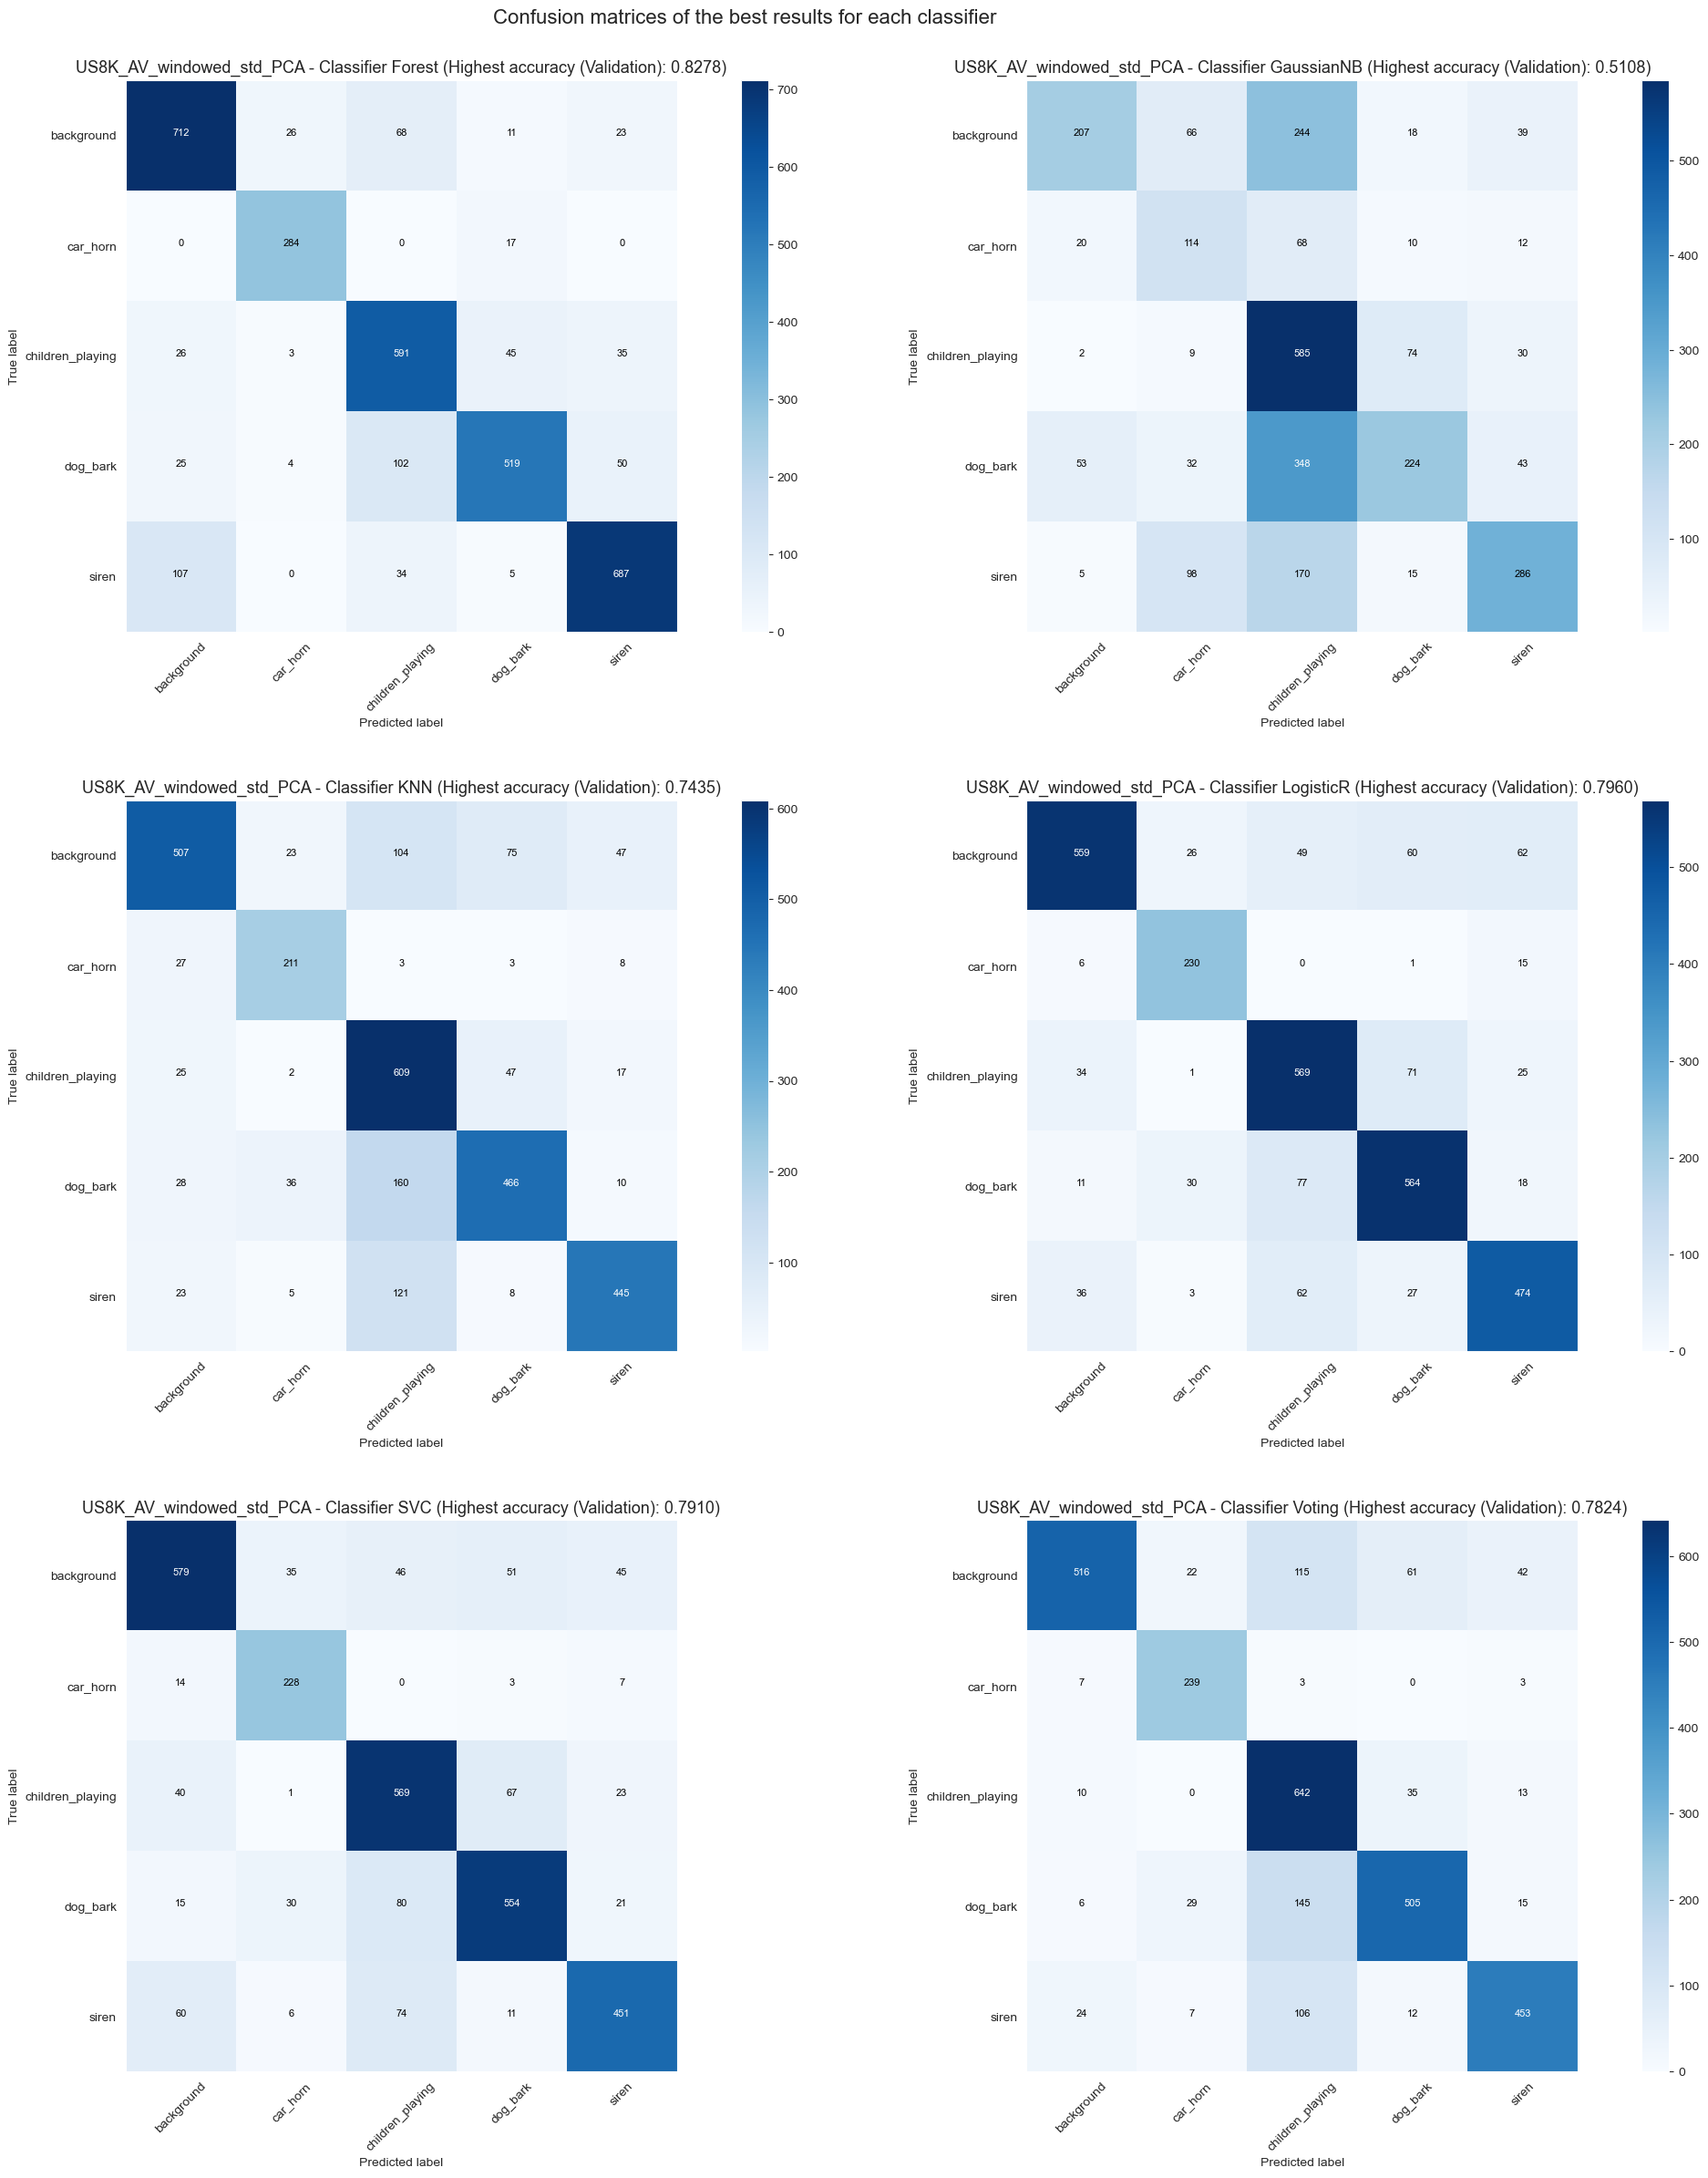

In [34]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(25,25))
plt.suptitle('Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.97)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = nom_dataset + model_surname + batch_name + ' - Classifier '+ i + ' (Highest accuracy (Validation): ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Validation)'])) +')'
    plt.subplot(3,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)
plt.tight_layout(pad=4.0)
plt.savefig(os.path.join(path_pic, picture_name))

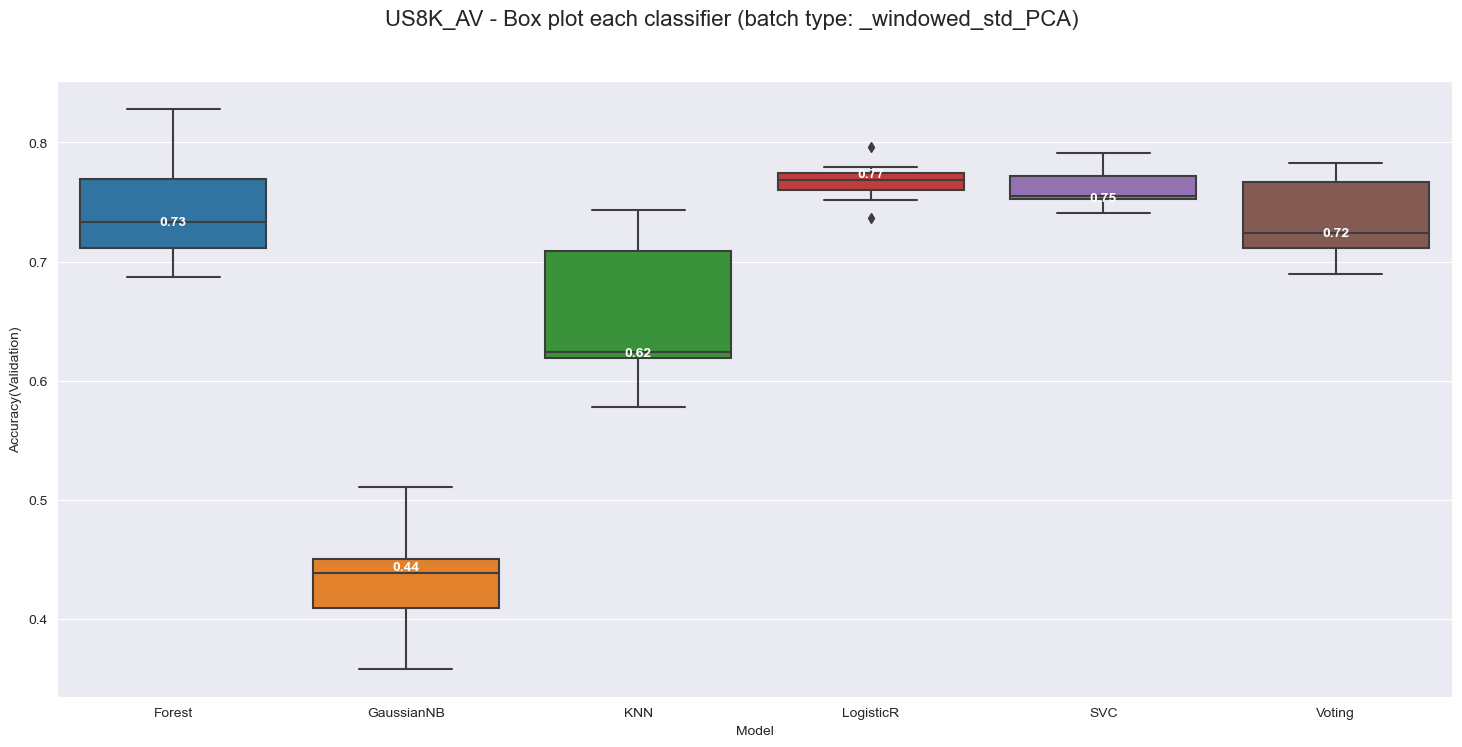

In [35]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname + batch_name})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Validation)", showfliers = True)

medians = list(metrics_set.groupby(['Model'], sort = False)['Accuracy(Validation)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Validation)'].median()*0.001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

## Results ESC-10

## Results BDLib2

## Results US8K

## Results US8K_AV

# End of notebook